# Clip raster with polygon: Extract Belgian data from Corine Land Cover geotiff

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import rasterio.plot
import rasterio.mask 

## Open-data sources

Sources:
- Corine Land Cover: https://land.copernicus.eu/en/products/corine-land-cover/clc2018#download
- Country borders: https://finances.belgium.be/fr/experts-partenaires/donnees-ouvertes-patrimoine/jeux-donnees/unites-administratives

## Import limits of Belgium

Import limits of of Belgium in a geopandas dataframe and reproject to coordinate system used by Corine Land Cover (3035)

<Axes: >

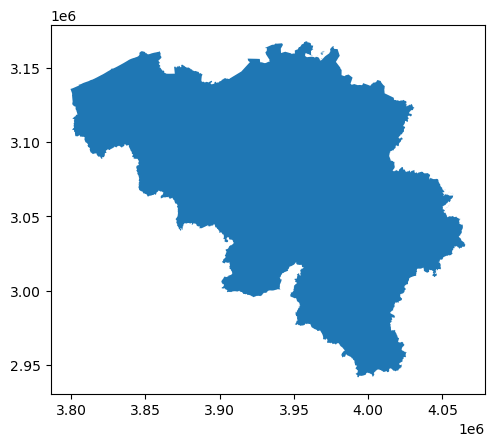

In [2]:
ref='input/agdp/Apn_AdCo.shp'
bordersOfBelgium=gpd.read_file(ref).to_crs(3035)
bordersOfBelgium.plot()

## Corine Land Cover

Is a very large file: around **200MB**.

In [3]:
clc4europe='input/clc/clc2018_clc2018_V2018.20b2.tif'

## Extract using rasterio.mask

We use the [rasterio.mask](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask) module to extract Belgium data from Corine Land Cover.

Options used in the mask function:
- crop=True: to crop the raster to the extent of the shapes
- all_touched=True: Include a pixel in the mask if it touches any of the shapes.

The mask function returns:
- a numpy.ndarray with data contained in the raster after applying the mask.
- an [affine.Affine](https://rasterio.readthedocs.io/en/latest/topics/transforms.html) object with information for mapping pixel coordinates in masked to another coordinate system.

In [4]:
with rasterio.open(clc4europe) as src:
    clc4europe_meta = src.meta
    clc4belgium_band, clc4belgium_affine = rasterio.mask.mask(src, shapes=bordersOfBelgium.geometry, crop=True, all_touched=True)

## Check the result

Corine code less than 150 are used to identify populated areas.

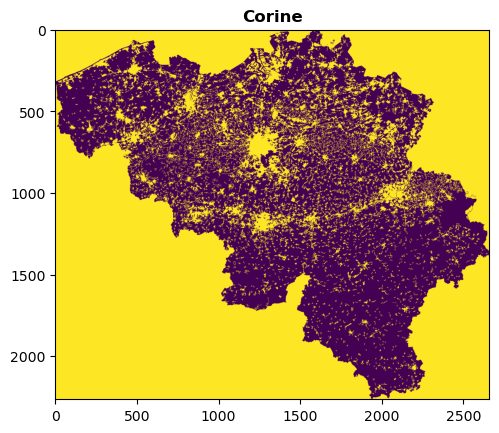

<Axes: title={'center': 'Corine'}>

In [5]:
rasterio.plot.show(clc4belgium_band<np.int16(150), title = "Corine")

## Correction of metadata

These metadata are the metadata from the Corine geotiff.
The width and heigth are these from Corine (that covers the whole of Europe).
We need to correct this !

In [6]:
clc4europe_meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 65000,
 'height': 46000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]'),
 'transform': Affine(100.0, 0.0, 900000.0,
        0.0, -100.0, 5500000.0)}

In [7]:
clc4belgium_band.shape

(1, 2264, 2659)

In [8]:
clc4belgium_meta=clc4europe_meta
_,clc4belgium_meta['height'],clc4belgium_meta['width']=clc4belgium_band.shape

In [9]:
clc4belgium_meta['transform']=clc4belgium_affine

Here are the metadata after metadata correction.

In [10]:
clc4belgium_meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 2659,
 'height': 2264,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]'),
 'transform': Affine(100.0, 0.0, 3799500.0,
        0.0, -100.0, 3168000.0)}

## Export of results to disk

In [11]:
with rasterio.open('output/belgium_clc.tif', 'w', **clc4belgium_meta) as dst:
    dst.write(clc4belgium_band)  # Write the masked data to the first band and close the file

## Check the result

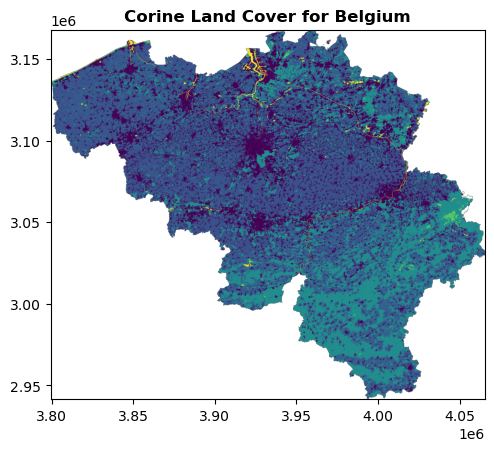

<Axes: title={'center': 'Corine Land Cover for Belgium'}>

In [12]:
ref = "output/belgium_clc.tif"
tiff = rasterio.open(ref)
rasterio.plot.show(tiff, title = "Corine Land Cover for Belgium")

## Compute some statistics

Count of hectares for each land cover codes.

In [13]:
import numpy as np
values, counts = np.unique(clc4belgium_band, return_counts=True)
distribution = dict(zip(values, counts))

In [14]:
distribution

{np.int16(-32768): np.int64(2941111),
 np.int16(111): np.int64(5166),
 np.int16(112): np.int64(506175),
 np.int16(121): np.int64(57996),
 np.int16(122): np.int64(10624),
 np.int16(123): np.int64(7470),
 np.int16(124): np.int64(5515),
 np.int16(131): np.int64(6737),
 np.int16(132): np.int64(803),
 np.int16(133): np.int64(2179),
 np.int16(141): np.int64(4768),
 np.int16(142): np.int64(20630),
 np.int16(211): np.int64(669027),
 np.int16(222): np.int64(9129),
 np.int16(231): np.int64(353723),
 np.int16(242): np.int64(533115),
 np.int16(243): np.int64(188204),
 np.int16(311): np.int64(209393),
 np.int16(312): np.int64(134446),
 np.int16(313): np.int64(268849),
 np.int16(321): np.int64(949),
 np.int16(322): np.int64(29811),
 np.int16(324): np.int64(19091),
 np.int16(331): np.int64(1275),
 np.int16(411): np.int64(2590),
 np.int16(412): np.int64(5612),
 np.int16(421): np.int64(819),
 np.int16(423): np.int64(2087),
 np.int16(511): np.int64(6113),
 np.int16(512): np.int64(10575),
 np.int16(522):

In [15]:
sum([distribution[k] for k in distribution.keys() if k!=np.int16(-32768)])

np.int64(3078865)